In [4]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.colors as colors

import networkx as nx
import community as community_louvain

import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster, PolyLineTextPath
from collections import Counter

from datetime import datetime
import calendar
import holidays
import datetime

import os
import requests
from zipfile import ZipFile
from io import BytesIO

import ipywidgets as widgets
from IPython.display import display, clear_output, IFrame
import time
import asyncio

from html2image import Html2Image
import seaborn as sns


### Download and open the dataset

In [5]:
base_url = "https://s3.amazonaws.com/hubway-data/"

def download_and_unzip(year, month):
    if year < 2018 or (year == 2018 and month < 5):
        brand = 'hubway'
    else:
        brand = 'bluebikes'

    filename = f"{year}{month:02d}-{brand}-tripdata.zip"
    filepath = os.path.join(f"{year}{month:02d}-{brand}-tripdata")  # replace with your local path

    # Download if the file does not exist in the device
    if not os.path.exists(filepath):
        print(f"Downloading {filename}...")
        response = requests.get(base_url + filename, stream=True)
        response.raise_for_status()
        
        # Unzip
        with ZipFile(BytesIO(response.content)) as thezip:
            print("Unzipping...")
            thezip.extractall(f"{year}{month:02d}-{brand}-tripdata") 
            print(f"Unzipped to {year}{month:02d}-{brand}-tripdata")
    else:
        print(filename,"already exists.")
    
    df_full = pd.read_csv(f"{year}{month:02d}-{brand}-tripdata/{year}{month:02d}-{brand}-tripdata.csv")
    df_full.replace('\\N', np.nan, inplace=True)
    df_full = df_full.dropna() #if the data contains NA, drop the row
    
    # Change the name of the column so that it is similar in all brand name
    if brand == 'bluebikes':
        df_full.rename(columns={'started_at': 'starttime'}, inplace=True)
        df_full.rename(columns={'ended_at': 'stoptime'}, inplace=True)
        df_full.rename(columns={'start_station_id': 'start station id'}, inplace=True)
        df_full.rename(columns={'end_station_id': 'end station id'}, inplace=True)
        df_full.rename(columns={'start_lat': 'start station latitude'}, inplace=True)
        df_full.rename(columns={'start_lng': 'start station longitude'}, inplace=True)
        df_full.rename(columns={'end_lat': 'end station latitude'}, inplace=True)
        df_full.rename(columns={'end_lng': 'end station longitude'}, inplace=True)
        df_full.rename(columns={'member_casual': 'usertype'}, inplace=True)
               
    return(df_full)

### Filter based on date and time

In [3]:
def filter_date_time(df, year, month, start_day, start_hour, start_minute, end_day, end_hour, end_minute, weekend=False):
    
    # Define holidays for Massachusetts, USA
    usa_holidays = holidays.UnitedStates(years=year, state='MA')
    
    # Ensure starttime and stoptime are in datetime format
    df['starttime'] = pd.to_datetime(df['starttime'])
    df['stoptime'] = pd.to_datetime(df['stoptime'])
    
    # Calculate trip duration in seconds
    if 'tripduration' not in df.columns:
        df['tripduration'] = (df['stoptime'] - df['starttime']).dt.total_seconds()
    
    # Define the weekday and weekend conditions
    if weekend:
        day_condition = (df['starttime'].dt.dayofweek >= 5)  # Saturday (5) and Sunday (6)
    else:
        day_condition = (df['starttime'].dt.dayofweek >= 0) & (df['starttime'].dt.dayofweek <= 4)  # Monday to Friday (0-4)
    
    # Filter trips within the specified time range
    filtered_data = df[
        (df['starttime'].dt.year == year) &
        (df['starttime'].dt.month == month) &
        (df['starttime'].dt.day >= start_day) & 
        (df['starttime'].dt.day <= end_day) &  # Ensure start and stop times fall within the same day
        (df['starttime'].dt.hour >= start_hour) &  # Starting at start_hour
        (df['starttime'].dt.minute >= start_minute) &  # Starting at or after start_minute
        (
            (df['stoptime'].dt.date == df['starttime'].dt.date) &  # Stop time is on the same day as start time
            (
                (df['starttime'].dt.hour < end_hour)   # Ending before end_hour
                # ((df['starttime'].dt.hour == end_hour-1) & (df['starttime'].dt.minute <= end_minute))  # Ending at or after end_minute
            )
        ) &
        day_condition &  # Apply the day condition based on weekend parameter
        (~df['starttime'].dt.date.isin(usa_holidays)) &
        (df['tripduration'] > 60) &  # Longer than 60 seconds
        (df['tripduration'] <= 3600)  # No longer than 3600 seconds
    ]
    
    filtered_data.reset_index(drop=True, inplace=True)
      
    return filtered_data

### Full function filtering and information extraction

In [4]:
def initial_cleaning (month, year, start_hour, end_hour, bsn_full = None, weekend=False):#, age=45):
    '''
    INPUT
    month      : Integer signifies the month of analysis
    year       : Integer signifies the year of analysis
    start_hour : Integer signifies the start hour of analysis 
    end_hour   : Integer signifies the end hour of analysis
    
    OUTPUT 
    data_filt    : Dataframe containing complete data of the trips that have already been filtered 
    tc           : Dataframe containing information regarding the number of trips between stations 
    stations_loc : Dataframe containing information about the latitude and longitude of each station 
    '''
    # Download/open the file 
    if bsn_full is None:
        bsn_full = download_and_unzip(int(year), int(month))
    
    # Filter date and time 
    start_year = year
    start_month = month
    end_year = year
    end_month = month

    start_day = 1
    _, end_day = calendar.monthrange(year, month) # automatically take the last date of the month
    start_minute = 0
    end_minute = 59
    
    end_hour = end_hour

    data_filt = filter_date_time(bsn_full, year, month, start_day, start_hour, start_minute, end_day, end_hour, end_minute, weekend)
    
    # Filter self-loop, member only
    data_filt = data_filt[data_filt['start station id'] != data_filt['end station id']]
    data_filt = data_filt[data_filt['usertype'].isin(['Subscriber', 'member'])]
    # data_filt = data_filt[data_filt['birth year'].astype(int)>=(year-age)]
    data_filt.reset_index(drop=True, inplace=True)
    
    # Trip_counts
    tc = data_filt.groupby(['start station id', 'end station id','start station latitude', 'start station longitude', 
                            'end station latitude', 'end station longitude']).size().reset_index(name='trip_count')
    
    # Location of the stations
    start_stations = data_filt[['start station id', 'start station latitude', 'start station longitude']].copy()
    end_stations = data_filt[['end station id', 'end station latitude', 'end station longitude']].copy()

    start_stations.columns = ['station id', 'latitude', 'longitude']
    end_stations.columns = ['station id', 'latitude', 'longitude']

    stations_loc= pd.concat([start_stations, end_stations], ignore_index=True)
    stations_loc = stations_loc.drop_duplicates(subset='station id').reset_index(drop=True)
    stations_loc['station id'] = stations_loc['station id']#.astype(int)
    stations_loc = stations_loc.sort_values(by='station id', ascending=True).reset_index(drop=True)# Delete any duplicates
    
    return data_filt, tc, stations_loc

In [5]:
def elim_stations(before_data, before_tripcount, before_stations, after_data, after_tripcount, after_stations):
    '''
    This function eliminate the stations that only exist on 2018 and not exist in 2016
    '''

    old_stations = after_stations[after_stations['station id'].isin(before_stations['station id'])]
    new_stations = after_stations[~after_stations['station id'].isin(before_stations['station id'])]
    
    data_old = after_data[
        after_data['start station id'].isin(before_stations['station id']) & 
        after_data['end station id'].isin(before_stations['station id'])
    ]
    
    tripcount_old = after_tripcount[
        after_tripcount['start station id'].isin(before_stations['station id']) & 
        after_tripcount['end station id'].isin(before_stations['station id'])
    ]

    return data_old, tripcount_old, old_stations, new_stations

In [6]:
starth = 6
endh =23
mon = 5
year1 = 2016
year2 = 2018

In [7]:
data_16, trip_counts_16, stations_loc_16 = initial_cleaning (month = mon, year = year1, start_hour = starth , end_hour = endh)

201605-hubway-tripdata.zip already exists.


In [8]:
data_18, trip_counts_18, stations_loc_18 = initial_cleaning (month = mon, year = year2, start_hour = starth , end_hour = endh)

201805-bluebikes-tripdata.zip already exists.


### Preliminary Statisical Analysis Year Before and After

In [9]:
data_18, trip_counts_18, stations_loc_18, new_stations_18 = elim_stations(data_16, trip_counts_16, stations_loc_16, data_18, trip_counts_18, stations_loc_18)

In [10]:
dif_num_trips = len(data_18) - len(data_16)
print('Different number of trips are', dif_num_trips, 'trips')

Different number of trips are 22955 trips


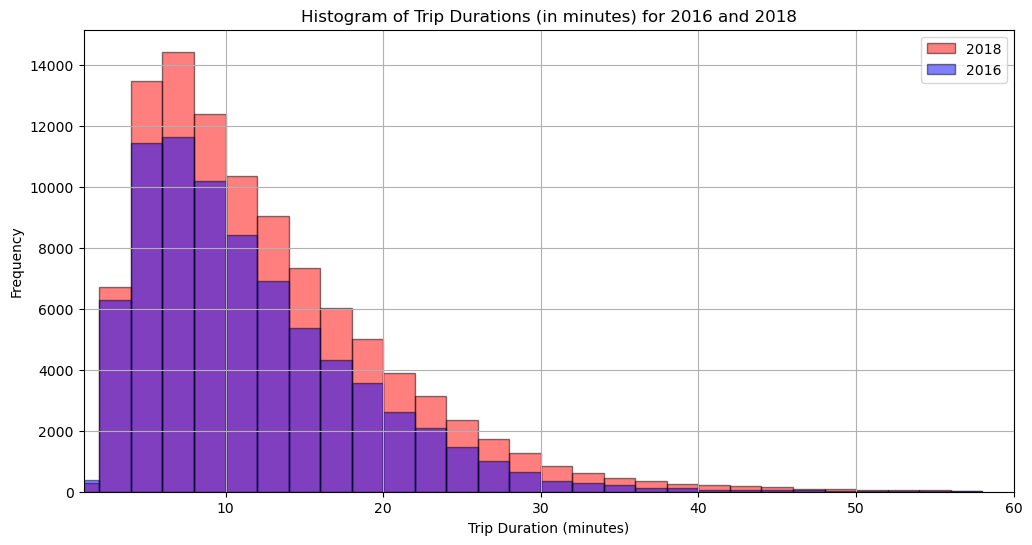

In [11]:
data_16['tripduration_minutes'] = data_16['tripduration'] / 60
data_18['tripduration_minutes'] = data_18['tripduration'] / 60

bins = range(0, 60, 2)

plt.figure(figsize=(12, 6))
plt.hist(data_18['tripduration_minutes'], bins=bins, alpha=0.5, label='2018', color='red', edgecolor='black')
plt.hist(data_16['tripduration_minutes'], bins=bins, alpha=0.5, label='2016', color='blue', edgecolor='black')
plt.title('Histogram of Trip Durations (in minutes) for 2016 and 2018')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.xlim(1,60)
plt.grid(True)
plt.show()

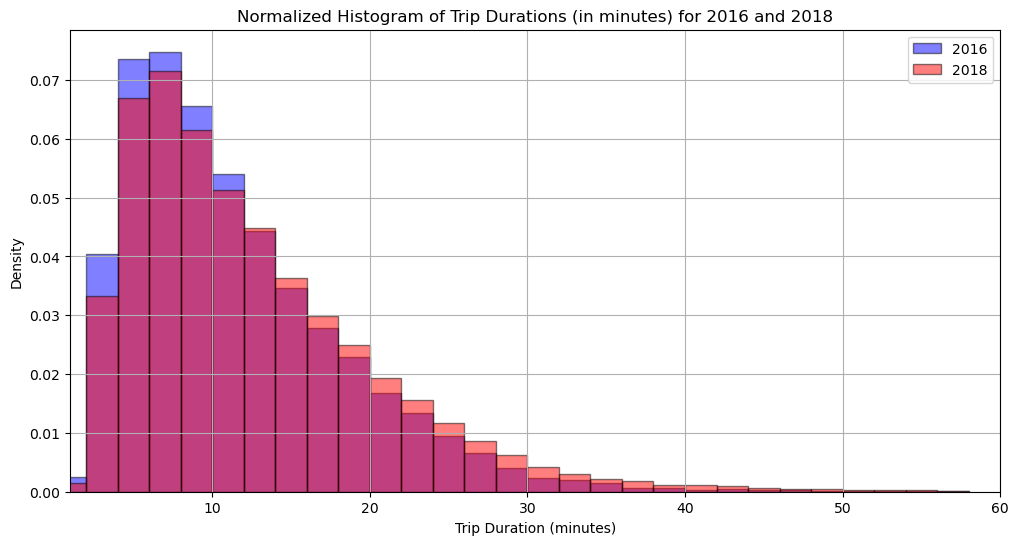

In [12]:
data_16['tripduration_minutes'] = data_16['tripduration'] / 60
data_18['tripduration_minutes'] = data_18['tripduration'] / 60

bins = range(0, 60, 2)

# Plot normalized
plt.figure(figsize=(12, 6))
hist_16, bins_16, _ = plt.hist(data_16['tripduration_minutes'], bins=bins, alpha=0.5, label='2016', color='blue', edgecolor='black', density=True)
hist_18, bins_18, _ = plt.hist(data_18['tripduration_minutes'], bins=bins, alpha=0.5, label='2018', color='red', edgecolor='black', density=True)
plt.title('Normalized Histogram of Trip Durations (in minutes) for 2016 and 2018')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlim(1, 60)
plt.show()

In [13]:
map_center = [new_stations_18['latitude'].mean(), new_stations_18['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=11, tiles='CartoDB positron')

# Add markers for each new station
for _, station in new_stations_18.iterrows():

    folium.CircleMarker(
            location=[station['latitude'], station['longitude']],
            radius=3,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7,
             popup=f"Station ID: {station['station id']}"
        ).add_to(m)

for _, station in stations_loc_18.iterrows():

    folium.CircleMarker(
            location=[station['latitude'], station['longitude']],
            radius=3,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            popup=f"Station ID: {station['station id']}"
        ).add_to(m)

legend_html = f'''
     <div style="position: fixed; 
                 top: 10px; right: 20px; width: 150px; height: 80px; 
                 background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
                 ">
     &nbsp; <b>Legend</b> <br>
     &nbsp; <i class="fa fa-circle" style="color:red"></i>&nbsp; New Stations <br>
     &nbsp; <i class="fa fa-circle" style="color:blue"></i>&nbsp; Old Stations
     </div>
     '''

m.get_root().html.add_child(folium.Element(legend_html))
m

In [14]:
# [110.108,89]

### Network of the Bike Sharing

In [15]:
def create_network(trip_count_df, stations_locs, plot=False):
    '''
    INPUT 
    trip_count_df  : Dataframe containing the start station, end station, and trip count 
    stations_locs  : Dataframe containing the stations and its location coordinates
    
    OUPUT
    BSN     : Bidirectional graph 
    UNDIR   : Undirected graph
    adj_df  : Dataframe of the adjacency matrix of the bidirectional graph
    '''
    # Create Bidirectional graph
    BSN = nx.DiGraph()

    # Add edges for everytrip between the nodes(stations)
    for _, row in trip_count_df.iterrows():
        BSN.add_edge((row['start station id']), (row['end station id']), weight=(row['trip_count']))
        
    # Calculate the adjacency matrix
    adj_mat = nx.adjacency_matrix(BSN)
    # Reformating to pandas dataframe
    adj_df = pd.DataFrame(adj_mat.todense().astype(int), index=BSN.nodes(), columns=BSN.nodes()) 
    
    # Create the undirected network with the edges only register if exist both direction and the weight is the sum of both weights
    UNDIR = nx.Graph()
    for u, v, data in BSN.edges(data=True):
        
        #### Normal Undirected
        if UNDIR.has_edge(u, v):
            # If the edge already exists in the undirected graph, add the weight
            UNDIR[u][v]['weight'] += data['weight']
        else:
            # If the edge doesn't exist, create it with the current weight
            UNDIR.add_edge(u, v, weight=data['weight'])
    
    if plot == True:
        plt.figure(figsize=(17, 17)) 

        # pos = nx.kamada_kawai_layout(BSN)  # layout option 1
        pos = {row['station id']: (row['longitude'], row['latitude']) for idx, row in stations_locs.iterrows()} #layout based on coordinates
        # nx.draw(BSN, pos, with_labels=True, node_size=500, node_color='lightblue', arrows=True, edge_color='grey', alpha=1)
        nx.draw_networkx_nodes(BSN, pos, node_size=500, node_color='lightblue')
        nx.draw_networkx_edges(BSN, pos, edge_color='grey', arrows=True, alpha=0.2)
        # nx.draw_networkx_labels(BSN, pos)

        plt.axis('off')
        plt.title('Network of the Bike Sharing')

        plt.show()
    
    return BSN, UNDIR, adj_df      

In [16]:
BSN16, UNDIR16, adj16 = create_network(trip_counts_16, stations_loc_16, plot=False)
BSN18, UNDIR18, adj18 = create_network(trip_counts_18, stations_loc_18, plot=False)

In [17]:
print("Sanity check if the number of trip after data in the adjacency matrix match of that in the trips database:", adj16.sum().sum() == len(data_16))
print("Sanity check if the number of trip before data in the adjacency matrix match of that in the trips database:", adj18.sum().sum() == len(data_18))

Sanity check if the number of trip after data in the adjacency matrix match of that in the trips database: True
Sanity check if the number of trip before data in the adjacency matrix match of that in the trips database: True


## Analysis 1 -- Community Comparison

#### Create Community - Louvain Algorithm

First, find the communities using the Louvain algorithm

Threshold : stopping criterion 
           If moving a node results in a modularity gain that is smaller than the threshold, 
           the algorithm concludes that it cannot meaningfully increase the modularity by further moves.
           When the modularity gain across all nodes is below this threshold, the algorithm stops.

Resolution : If resolution is less than 1, the algorithm favors larger communities. Greater than 1 favors smaller communities

In [18]:
# Function to find the best resolutions 
def com_finder (network,resolutions_range, plot=False):
    
    '''
    INPUT 
    network           : NetworkX format of Network 
    resolutions_range : List of possible values of resolution
    
    OUTPUT
    best_mod     : Value of the highest modularity 
    best_res     : Best resolution that produce best modularity
    commmunities : The list of nodes of communities 
    '''

    modularity_scores = []

    for res in resolutions_range:
        coms = nx.community.louvain_communities(network, weight='weight', resolution=res, threshold=1e-8, seed=123123)
        modularity = nx.community.modularity(network, coms, weight='weight')
        modularity_scores.append(modularity)
        
    best_mod = np.max(modularity_scores)
    best_res = resolutions_range[np.argmax(modularity_scores)]
    # print("Best resolution is on", best_res, "with the value of modularity is", np.round(best_mod,2))
    
    communities = nx.community.louvain_communities(network, weight='weight',resolution=best_res, threshold=1e-8, seed=123123)
        
    if plot:    
        plt.figure(figsize=(10, 5))
        plt.plot(resolutions_range, modularity_scores, marker='o', color='red')
        plt.title('Modularity vs. Resolution')
        plt.xlabel('Resolution')
        plt.ylabel('Modularity Score')
        plt.grid(True)
        plt.show()
        
    return best_mod, best_res, communities

In [19]:
# bmod16, bres16, commun16 = com_finder(BSN16, resolutions_range = [0.2,0.5,0.8,0.9,1,1.1,1.2,1.5,1.8], plot=True)
bmod16, bres16, commun16 = com_finder(BSN16, resolutions_range = [1], plot=False)

In [20]:
# bmod18, bres18, commun18 = com_finder(BSN18, resolutions_range = [0.2,0.5,0.8,0.9,1,1.1,1.2,1.5,1.8], plot=True)
bmod18, bres18, commun18 = com_finder(BSN18, resolutions_range = [1], plot=False)

## Plotting of the communities and heatmap

In [21]:
# Coordinates of Cambridge Street and Oxford Street 
cam_str = [(42.373918, -71.102282),(42.374924, -71.110130),(42.375454, -71.114163)]
# ox_str = [(42.386056, -71.116185),(42.385192, -71.116162),(42.384312, -71.116105),(42.383633, -71.116101),(42.378770, -71.116624),(42.376446, -71.115758)]

In [22]:
colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'gray', 'brown', 'cyan',
     'magenta', 'lime', 'maroon', 'olive', 'navy', 'teal', 'aqua', 'fuchsia', 'silver'
]

# colors = ['cyan', 'lime', 'olive', 'navy', 'teal', 'aqua', 'fuchsia', 'silver', 'brown']

In [23]:
def create_community_color_df(communities, colors):
    """
    INPUT
    communities : Each set contains the node IDs of a community.
    colors      : List of strings containing the colors to assign to each community.

    OUPUT
    community_color_df : DataFrame with columns containing the nodes, the community they belong, and the color associated
    """
    sorted_communities = sorted(communities, key=lambda x: min(x))
    
    community_color_data = []
    for idx, community in enumerate(sorted_communities):
        color = colors[idx % len(colors)]
        for node in sorted(community):
            community_color_data.append((node, idx, color))
    
    community_color_df = pd.DataFrame(community_color_data, columns=['Node', 'Community', 'Color'])
    
    if pd.api.types.is_float_dtype(community_color_df['Node']):
        community_color_df['Node'] = community_color_df['Node'].astype(int)  
    
    return community_color_df

In [24]:
def plot_community(communities, stations_locs_df, zoom, month, year, time, central_node):
    '''
    INPUT
    communities        : List of sets containing stations that are grouped based on the communities
    stations_locs_df   : DataFrame containing the stations and their location coordinates
    zoom               : Initial zoom level for the map
    month              : Month for the analysis
    year               : Year for the analysis
    time               : Time for the analysis
    central_node       : Station ID of the central node to be highlighted

    OUTPUT
    community_color_df : DataFrame mapping each node to its community and color
    map_boston         : Folium map object with plotted stations and their communities
    '''

    map_center_latitude = stations_locs_df['latitude'].mean()
    map_center_longitude = stations_locs_df['longitude'].mean()

    # Use the function to create the community color DataFrame if the input is not already the processed DataFrame 
    if isinstance(communities, pd.DataFrame):
        community_color_df = communities 
    else:
        community_color_df = create_community_color_df(communities, colors)  
    
    node_to_color = community_color_df.set_index('Node')['Color'].to_dict()

    # Create the map
    map_boston = folium.Map(location=[map_center_latitude, map_center_longitude], tiles='CartoDB positron', zoom_start=zoom)

    folium.PolyLine(cam_str, color='blue', weight=4, opacity=1).add_to(map_boston)
    folium.PolyLine(ox_str, color='olive', weight=4, opacity=1).add_to(map_boston)

    the_existence = False

    # Plot the stations, colored by community
    for _, row in stations_locs_df.iterrows():
        station_id = row['station id']
        station_coords = [row['latitude'], row['longitude']]
        station_color = node_to_color.get(station_id, "white")
        
        # Determine the border color
        if station_id == central_node:
            border_color = "teal"
        else:
            border_color = station_color

        if station_id == 109:
            lat_offset = 0.001 
            lon_offset = -0.001  
            station_coords = [station_coords[0] + lat_offset, station_coords[1] + lon_offset]  
            folium.CircleMarker(
                location=station_coords,
                popup=f'Station ID: {station_id}',
                radius=5,
                color=border_color,
                fill=True,
                fill_color=station_color,
                fill_opacity=0.7
            ).add_to(map_boston)

            
        folium.CircleMarker(
            location=station_coords,
            popup=f'Station ID: {station_id}',
            radius=5,
            color=border_color,
            fill=True,
            fill_color=station_color,
            fill_opacity=0.7
        ).add_to(map_boston)

    # Stations Markers
    stations = [
        (42.3770, -71.1167, 'Harvard Square Station'),
        (42.388505, -71.119198, 'Porter Square Station'),
        (42.365338, -71.103418, 'Central Station'),
        (42.362400, -71.085570, 'Kendall/MIT Station'),
        (42.395579, -71.142624, 'Alewife Station'),
        (42.356331, -71.062290, 'Park Street Station')
    ]

    for lat, lon, name in stations:
        folium.CircleMarker(location=[lat, lon], radius=6, popup=name,
                            color='black', fill=True, fill_color='grey', fill_opacity=1).add_to(map_boston)

    month_name = datetime.date(year, month, 1).strftime('%b')
    formatted_time = f"{time:02}:00"
    formatted_string = f"{month_name} {year}, {formatted_time}"

    legend_html = f'''
    <div style="position: fixed; 
                top: 30px; right: 50px; width: 170px; height: 40px; 
                border:3px solid grey; z-index:9999; font-size:20px;
                ">&nbsp;{formatted_string}
    </div>
    '''
    map_boston.get_root().html.add_child(folium.Element(legend_html))

    return community_color_df, map_boston

In [25]:
from math import radians, sin, cos, sqrt, atan2
def haversine(coord1, coord2):
    R = 6371.0  # Earth rad in km 

    lat1, lon1 = radians(coord1[0]), radians(coord1[1])
    lat2, lon2 = radians(coord2[0]), radians(coord2[1])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c

    return distance

def midpoint(coord1, coord2):
    return [(coord1[0] + coord2[0]) / 2, (coord1[1] + coord2[1]) / 2]

In [26]:
def plot_heatmap(direction_df, trip_df1, trip_df2, location_df, month, year, time, zoom, op, dead_stations_df):

    map_center_latitude = location_df.iloc[:,1].mean()-0.005
    map_center_longitude = location_df.iloc[:,2].mean()

    map_boston = folium.Map(location=[map_center_latitude, map_center_longitude], 
                           tiles='CartoDB positron', zoom_start=zoom)

    marker_cluster = MarkerCluster(options={'maxClusterRadius': 0.1}).add_to(map_boston)
    color = ["purple","orange"]


    for idx, row in dead_stations_df.iterrows():    
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            # popup=f"Start Station ID: {row['station id']}",
            color='grey',
            fill=True,
            fill_color='grey',
            fill_opacity=0.4,
        ).add_to(map_boston)

    for i in range(2):
        trip_df = trip_df1 if i == 0 else trip_df2
        if trip_df.empty:
            continue
        max_weight = max(trip_df['trip_count'])
        min_weight = min(trip_df['trip_count'])

        for idx, row in trip_df.iterrows():
            start_coords = [row['start station latitude'], row['start station longitude']]
            end_coords = [row['end station latitude'], row['end station longitude']]

            folium.CircleMarker(
                location=start_coords,
                radius=5,
                popup=f"Start Station ID: {row['start station id']}",
                color='red',
                fill=True,
                fill_color='red',
                fill_opacity=0.7,
            ).add_to(map_boston)

            folium.CircleMarker(
                location=end_coords,
                radius=5,
                # popup=f"End Station ID: {row['end station id']}",
                color='red',
                fill=True,
                fill_color='red',
                fill_opacity=0.7,
            ).add_to(map_boston)


    for idx, row in dead_stations_df.iterrows():    
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            # popup=f"Start Station ID: {row['station id']}",
            color='grey',
            fill=True,
            fill_color='grey',
            fill_opacity=0.7,
        ).add_to(map_boston)
    

    # Define coordinates for the lines
    line_to_right = [(42.377945, -71.116865), (42.374035, -71.101427)]
    line_to_left = [(42.374035, -71.101427), (42.377945, -71.116865)]
    
    # Add the polyline for the right direction
    line_right = folium.PolyLine(
        locations=line_to_right,
        color='transparent',
        weight=0.5
    ).add_to(map_boston)
    
    # Add the polyline for the left direction
    line_left = folium.PolyLine(
        locations=line_to_left,
        color='transparent',
        weight=0.5
    ).add_to(map_boston)
    
    # Add arrows with specific colors for each direction
    # Arrow for the right direction
    arrow_right = PolyLineTextPath(
        line_right,
        '→',  # Pointing right
        repeat=True,
        offset=0,
        attributes={'fill': 'orange', 'font-weight': 'bold', 'font-size': '35px'}
    )
    map_boston.add_child(arrow_right)
    
    # Arrow for the left direction
    arrow_left = PolyLineTextPath(
        line_left,
        # '←',  # Pointing left
          '→',  # Pointing right
        repeat=True,
        offset=-50,
        attributes={'fill': 'purple', 'font-weight': 'bold', 'font-size': '35px'}
    )
    map_boston.add_child(arrow_left)

    
    # for idx, row in direction_df.iterrows():
    #     for _ in range(int(row.iloc[3])):
    #         folium.Marker(
    #             location=[row.iloc[1], row.iloc[2]],
    #             icon=folium.Icon(color='red', icon_size=(0, 0), icon_anchor=(0, 0))
    #         ).add_to(marker_cluster)

    for idx, row in direction_df.iterrows():
        for _ in range(int(row.iloc[3])):
            icon_html = '<div></div>'  # Empty DivIcon
            icon = folium.DivIcon(html=icon_html)
            folium.Marker(
                location=[row.iloc[1], row.iloc[2]],
                icon=icon
            ).add_to(marker_cluster)
    
    # Heatmap
    # heat_data = [[row.iloc[1], row.iloc[2], row.iloc[3]] for index, row in direction_df.iterrows()]
    # heatmap = HeatMap(heat_data)
    # map_boston.add_child(heatmap)


    folium.PolyLine(cam_str, color='blue', weight=5, opacity=op).add_to(map_boston)
    # folium.PolyLine(ox_str, color='olive', weight=5, opacity=1).add_to(map_boston)

    
    # Stations Markers
    stations = [
        (42.3770, -71.1167, 'Harvard Square Station'),
        (42.388505, -71.119198, 'Porter Square Station'),
        (42.365338, -71.103418, 'Central Station'),
        (42.362400, -71.085570, 'Kendall/MIT Station'),
        (42.395579, -71.142624, 'Alewife Station'),
        (42.356331, -71.062290, 'Park Street Station')
    ]

    for lat, lon, name in stations:
        folium.CircleMarker(location=[lat, lon], radius=6, popup=name,
                            color='black', fill=True, fill_color='grey', fill_opacity=1).add_to(map_boston)

    month_name = datetime.date(year, month, 1).strftime('%b')
    formatted_time = f"{time:02}:00"
    formatted_string = f"{month_name} {year}, {formatted_time}"

    legend_html = f'''

    <div style="position: fixed; 
                top: 30px; right: 50px; width: 170px; height: 40px; 
                border:3px solid grey; z-index:9999; font-size:20px;
                ">&nbsp;{formatted_string}
    </div>

    
    '''
    map_boston.get_root().html.add_child(folium.Element(legend_html))


    side_left_circ = [(42.361667, -71.13802), (42.376369, -71.114025)]
    side_right_circ = [(42.374035, -71.101427), (42.348203, -71.037651)]

    # Calculate midpoints and distances
    left_circle_center = midpoint(side_left_circ[0], side_left_circ[1])
    right_circle_center = midpoint(side_right_circ[0], side_right_circ[1])

    left_circle_radius = haversine(side_left_circ[0], side_left_circ[1]) * 500  # Convert to meters
    right_circle_radius = haversine(side_right_circ[0], side_right_circ[1]) * 500  # Convert to meters

    # Add circles encompassing left and right sides
    folium.Circle(
        location=left_circle_center,
        radius=left_circle_radius +150,  # Radius in meters
        color='orange',
        fill=True,
        weight=2
    ).add_to(map_boston)

    folium.Circle(
        location=right_circle_center,
        radius=right_circle_radius+150,  # Radius in meters
        color='purple',
        fill=True,
        weight=2
    ).add_to(map_boston)


    return map_boston

## Partial Functions

In [27]:
def the_spots(coordinate, num_stats, stations_loc):
    '''
    INPUT
    coordinate   : Array of (latitude,longitude)
    num_stats    : Integer corresponds to the number of stations closest to the target streets
    stations_loc : Dataframe containing the stations and its location coordinates
    
    OUTPUT 
    stationz = the name of the closest stations to the coordinnate
    '''
    d1 = np.array([stations_loc['latitude'], stations_loc['longitude']]).T - coordinate.reshape(1, 2)
    dst = np.linalg.norm(d1, axis=1)
    idx_closest = np.argsort(dst)[:num_stats]
    stationz = stations_loc.iloc[idx_closest]['station id'].tolist()
            
    return stationz

In [28]:
def partial_graph_data(closest_stations, trip_counts_df, station_locs_df, data_df):
    '''
    INPUT
    closest_stations   : List or list of lists of closest stations to the target street
    trip_count_df      : Dataframe containing the start station, end station, and trip count 
    stations_loc       : Dataframe containing information about the latitude and longitude of each stations 
    data_df            : DataFrame full information about the bike trip


    OUTPUT 
    trips_spot           : Dataframe containing the information regarding the trips between the closest stations
    stations_loc_partial : Dataframe containing the information about the latitude and longitude of each closest stations 
    partial              : Directed graph of the closest stations
    '''
    
    if isinstance(closest_stations[0], list):
        # Handle input as list of lists
        set1 = set(closest_stations[0])
        set2 = set(closest_stations[1])
        
        # Filter trips between set1 and set2 (or reverse)
        trips_spot = trip_counts_df[
            ((trip_counts_df['start station id'].isin(set1)) & (trip_counts_df['end station id'].isin(set2))) |
            ((trip_counts_df['start station id'].isin(set2)) & (trip_counts_df['end station id'].isin(set1)))
        ].reset_index(drop=True)

        data_spot = data_df[
            ((data_df['start station id'].isin(set1)) & (data_df['end station id'].isin(set2))) |
            ((data_df['start station id'].isin(set2)) & (data_df['end station id'].isin(set1)))
        ].reset_index(drop=True)
        
        # Filter station locations
        filtered_stations = set1.union(set2)
        stat_loc_spot = station_locs_df[station_locs_df['station id'].isin(filtered_stations)].reset_index(drop=True)
    else:
        # Handle input as a single list
        trips_spot = trip_counts_df[
            (trip_counts_df['start station id'].isin(closest_stations)) & 
            (trip_counts_df['end station id'].isin(closest_stations))
        ].reset_index(drop=True)

        data_spot = data_df[
            ((data_df['start station id'].isin(closest_stations)) & (data_df['end station id'].isin(closest_stations)))
        ].reset_index(drop=True)
        
        # Filter station locations
        stat_loc_spot = station_locs_df[station_locs_df['station id'].isin(closest_stations)].reset_index(drop=True)
    
    # Make the graph
    partial = nx.DiGraph()
    for _, row in trips_spot.iterrows():
        partial.add_edge(row['start station id'], row['end station id'], weight=row['trip_count'])
            
    return trips_spot, stat_loc_spot, data_spot, partial

## Testing

In [29]:
def jaccard_index(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    if not union:
        return 0.0
    return len(intersection) / len(union)

In [30]:
def geometric_median(coords):
    """
    Compute the geometric median of a numpy array of coordinates.
    """
    def L1_norm(x):
        return np.sum(np.linalg.norm(coords - x, axis=1))

    # Initial guess: simply use the mean
    initial_guess = np.mean(coords, axis=0)

    result = minimize(L1_norm, initial_guess, method='BFGS')
    return result.x

def calculate_center_of_mass(df):
    """ Calculate the geometric center for each community based on longitude and latitude. """
    centroids = df.groupby('Community').apply(
        lambda g: geometric_median(g[['longitude', 'latitude']].values),
        include_groups=False  # Add this parameter to comply with future pandas updates
    )
    return centroids.to_dict()


def find_closest_anchor(center_of_mass, anchors):
    """ Find the closest anchor to a given center of mass. """
    closest = min(anchors, key=lambda x: np.linalg.norm(np.array(center_of_mass) - np.array((x['Longitude'], x['Latitude']))))
    return closest['Community'], closest['Color']

def assign_colors_based_on_proximity(centroids, anchors, available_colors):
    # Step 1: Calculate distances from each community to each anchor
    distances = {}
    for comm, center in centroids.items():
        for anchor_id, anchor_details in anchors.items():
            if comm not in distances:
                distances[comm] = {}
            distances[comm][anchor_id] = np.linalg.norm(np.array(center) - np.array((anchor_details['Longitude'], anchor_details['Latitude'])))

    # Step 2: Determine the closest community for each anchor
    closest_communities = {}
    for anchor_id in anchors:
        closest_community = min(distances, key=lambda x: distances[x][anchor_id])
        closest_communities[closest_community] = anchor_id

    # Step 3: Assign anchor colors to closest communities and other colors to the rest
    color_mapping = {}
    used_colors = set()
    for comm, anchor_id in closest_communities.items():
        anchor_color = anchors[anchor_id]['Color']
        color_mapping[comm] = anchor_color
        used_colors.add(anchor_color)

    # Ensure unique colors for other communities
    remaining_colors = [color for color in available_colors if color not in used_colors]
    color_iter = iter(remaining_colors)
    for comm in centroids:
        if comm not in color_mapping:
            try:
                color_mapping[comm] = next(color_iter)
            except StopIteration:
                # Reset iterator if there are more communities than remaining colors
                color_iter = iter(remaining_colors)
                color_mapping[comm] = next(color_iter)

    return color_mapping
    
def enhanced_color_assignment(previous_df, current_df, available_colors, anchors):

    previous_communities = {k: set(g['Node']) for k, g in previous_df.groupby('Community')}
    current_communities = {k: set(g['Node']) for k, g in current_df.groupby('Community')}
    community_sizes = {k: len(v) for k, v in current_communities.items()}
    
    mapping = {}
    jaccard_scores = {}
    for current, current_set in current_communities.items():
        best_match = None
        highest_jaccard = 0
        for previous, previous_set in previous_communities.items():
            j_index = jaccard_index(current_set, previous_set)
            if j_index > highest_jaccard:
                highest_jaccard = j_index
                best_match = previous
        mapping[current] = best_match
        jaccard_scores[current] = highest_jaccard

    reverse_mapping = {prev: [] for prev in previous_communities.keys()}
    for cur, prev in mapping.items():
        if prev is not None:
            reverse_mapping[prev].append(cur)

    # Calculate centers of mass
    previous_centroids = calculate_center_of_mass(previous_df)
    current_centroids = calculate_center_of_mass(current_df)
    
    color_mapping = {}
    used_colors = set(previous_df['Color'])
    available_color_iter = iter(available_colors)

    for prev, cur_list in reverse_mapping.items():
        color_mapping.update(assign_colors_based_on_proximity(current_centroids, anchors, available_colors))

    # Assign new colors to new communities or unassigned communities
    for cur in current_communities.keys():
        if cur not in color_mapping:
            color_mapping[cur] = next(available_color_iter, 'Fallback Color')

    current_df['Color'] = current_df['Community'].map(color_mapping)

    return current_df

In [31]:
def update_available_colors(previous_df):
    # all_colors = [
    #     'red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'gray', 'brown', 'cyan',
    #     'magenta', 'lime', 'maroon', 'olive', 'navy', 'teal', 'aqua', 'fuchsia', 'silver'
    # ]
    # all_colors = [ 'yellow', 'lime', 'cyan','magenta', 'brown', 'maroon', 'navy', 'aqua', 'fuchsia']
    all_colors = ['yellow', 'pink', 'gray', 'brown', 'cyan',
        'magenta', 'lime', 'maroon', 'olive', 'navy', 'teal', 'aqua', 'fuchsia', 'silver',
        'gold', 'coral', 'orchid', 'salmon', 'khaki', 'violet', 'turquoise', 'peachpuff',
        'lavender', 'plum', 'chocolate', 'tan', 'tomato', 'seagreen', 'skyblue', 'midnightblue'
    ]
    used_colors = set(previous_df['Color'])
    available_colors = [color for color in all_colors if color not in used_colors]
    return available_colors

In [32]:
anchors = {
    1: {'Longitude': -71.095993,
        'Latitude': 42.360839,
        'Color': 'red',
        'Community': int(0)  
    },
    2: {
        'Longitude':  -71.116865,
        'Latitude': 42.377945,
        'Color': 'green',
        'Community': int(1) 
    },

        3: {
        'Longitude': -71.126533,
        'Latitude': 42.402038,
        'Color': 'purple',
        'Community': int(2) 
    },

        4: {
        'Longitude': -71.069616,
        'Latitude': 42.345392,
        'Color': 'blue',
        'Community': int(3) 
    },    

        5: {
        'Longitude': -71.105221,
        'Latitude': 42.334073,
        'Color': 'orange',
        'Community': int(4) 
    }
}

In [33]:
all_colors = [ 'red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'gray', 'brown', 'cyan',
                'magenta', 'lime', 'maroon', 'olive', 'navy', 'aqua', 'fuchsia']

## Heatmap

In [34]:
def process_duration_data(data_afr, hour, month, year):
    
    # Median because it might be better in the case of skewed distribution
    tda = data_afr.groupby(['start station id', 'end station id'])['tripduration'].median().reset_index().astype(int)
    tda.rename(columns={'tripduration': 'median duration'}, inplace=True)

    tda['hour'] = hour
    tda['month'] = month
    tda['year'] = year
    
    return tda

In [35]:
def filter_partial(closest_stations, trip_counts_df, station_locs_df, data_df):
    
    # Handle input as list of lists
    set1 = set(closest_stations[0])
    set2 = set(closest_stations[1])
    
    # Filter trips between set1 and set2 (or reverse)
    trips_spot_1 = trip_counts_df[(trip_counts_df['start station id'].isin(set1)) & (trip_counts_df['end station id'].isin(set2))].reset_index(drop=True)
    trips_spot_2 = trip_counts_df[(trip_counts_df['start station id'].isin(set2)) & (trip_counts_df['end station id'].isin(set1))].reset_index(drop=True)


    data_spot_1 = data_df[(data_df['start station id'].isin(set1)) & (data_df['end station id'].isin(set2))].reset_index(drop=True)
    data_spot_2 = data_df[(data_df['start station id'].isin(set2)) & (data_df['end station id'].isin(set1))].reset_index(drop=True)

    # Location of the stations
    data_filt = pd.concat([trips_spot_1,trips_spot_2])
    start_stations = data_filt[['start station id', 'start station latitude', 'start station longitude']].copy()
    end_stations = data_filt[['end station id', 'end station latitude', 'end station longitude']].copy()

    start_stations.columns = ['station id', 'latitude', 'longitude']
    end_stations.columns = ['station id', 'latitude', 'longitude']

    stations_loc_spot= pd.concat([start_stations, end_stations], ignore_index=True)
    stations_loc_spot = stations_loc_spot.drop_duplicates(subset='station id').reset_index(drop=True)
    stations_loc_spot['station id'] = stations_loc_spot['station id']#.astype(int)
    stations_loc_spot = stations_loc_spot.sort_values(by='station id', ascending=True).reset_index(drop=True)# Delete any duplicates
    
    return trips_spot_1, trips_spot_2, data_spot_1, data_spot_2, stations_loc_spot

In [36]:
stations_total_df = pd.read_csv("result/stations_total_df.csv")

In [37]:
data_16_6, trip_counts_16_6, stations_loc_16_6 = initial_cleaning (month = 4, year = 2016, start_hour = 1 , end_hour = 23)

201604-hubway-tripdata.zip already exists.


In [38]:
def generate_heatmaps(years, months, hours, zoom_size, points_side_1, points_side_2, points_side_3, points_side_4, points_side_5, points_side_6, depart=True, weekend=False):
    maps = {}
    sp_df = pd.DataFrame()
    target_df = pd.DataFrame()
    all_data_df = pd.DataFrame()


    target =  points_side_1 + points_side_2
    target2 = points_side_3 + points_side_4
    target3 = points_side_5 + points_side_6
    

    for yy in years:
        if yy == 2016:
            op = 0.2
        else:
            op = 1
            
        for mm in months:
            bsn = download_and_unzip(int(yy), int(mm))

            for hour in hours:
                # Generate data for each hour
                data_total, trip_counts_total, stations_loc_total = initial_cleaning(month=mm, year=yy, start_hour=hour, end_hour=hour+1, bsn_full=bsn, weekend=weekend)  
                
                ## Trip counts 
                tdf = trip_counts_total.loc[(trip_counts_total['start station id'].isin(target)) | (trip_counts_total['end station id'].isin(target))].copy()
                tdf['hour'] = hour
                tdf['month'] = mm
                tdf['year'] = yy

                tdf2 = trip_counts_total.loc[(trip_counts_total['start station id'].isin(target2)) | (trip_counts_total['end station id'].isin(target2))].copy()   
                tdf2['hour'] = hour
                tdf2['month'] = mm
                tdf2['year'] = yy

                tdf3 = trip_counts_total.loc[(trip_counts_total['start station id'].isin(target3)) | (trip_counts_total['end station id'].isin(target3))].copy()   
                tdf3['hour'] = hour
                tdf3['month'] = mm
                tdf3['year'] = yy
                
                target_df = pd.concat([target_df, tdf, tdf2, tdf3], ignore_index=True)  
                target_df = target_df.drop_duplicates(ignore_index=True)

                ## Trip data
                dtf = data_total.loc[(data_total['start station id'].isin(target)) | (data_total['end station id'].isin(target))].copy()
                dtf2 = data_total.loc[(data_total['start station id'].isin(target2)) | (data_total['end station id'].isin(target2))].copy()
                dtf3 = data_total.loc[(data_total['start station id'].isin(target3)) | (data_total['end station id'].isin(target3))].copy()


                dtf['hour'] = hour
                dtf['month'] = mm
                dtf['year'] = yy

                dtf2['hour'] = hour
                dtf2['month'] = mm
                dtf2['year'] = yy

                dtf3['hour'] = hour
                dtf3['month'] = mm
                dtf3['year'] = yy
                
                all_data_df = pd.concat([all_data_df, dtf, dtf2, dtf3], ignore_index=True)  
                all_data_df = all_data_df.drop_duplicates(ignore_index=True)

                closest_stations=[points_side_1, points_side_2]
                tc1, tc2, d1, d2, sloc = filter_partial(closest_stations, trip_counts_total, stations_loc_total, data_total)

                closest_stations2=[points_side_3, points_side_4]
                tc3, tc4, d3, d4, sloc2 = filter_partial(closest_stations2, trip_counts_total, stations_loc_total, data_total)

                closest_stations3=[points_side_5, points_side_6]
                tc5, tc6, d5, d6, sloc3 = filter_partial(closest_stations3, trip_counts_total, stations_loc_total, data_total)

                
                data_afr = pd.concat([d1,d2,d3,d4,d5,d6])
                partial_df_afr = pd.concat([tc1,tc2,tc3,tc4,tc5,tc6])
                sloc_afr = pd.concat([sloc,sloc2,sloc3])
                target_total = np.unique(target+target2+target3)

                
                #If no edges or nodes detected, give empty map instead
                if len(data_afr) == 0:
                    map_boston = folium.Map(location=[42.373918, -71.102282], tiles='CartoDB positron', zoom_start=zoom_size)
                    result_folder = os.path.join("result", f"{yy}_{mm}")
                    os.makedirs(result_folder, exist_ok=True)
                    title = "depart" if depart else "arrive"
                    if weekend==True:
                        map_file = os.path.join(result_folder, f"map_hour_{hour}_mon_{mm}_year_{yy}_{title}_weekend.html")
                    else:    
                        map_file = os.path.join(result_folder, f"map_hour_{hour}_mon_{mm}_year_{yy}_{title}.html")
                    map_boston.save(map_file)
                    maps[(yy, mm, hour)] = map_file
                    continue
                
                unique_station_ids = sloc_afr['station id'].unique()
                dead_stations = [station for station in target_total if station not in unique_station_ids]
                dead_stations_df = stations_total_df[stations_total_df['station id'].isin(dead_stations)]
            

                if depart: 
                    df_ptaf = partial_df_afr.groupby(['start station id', 'start station latitude', 'start station longitude'])['trip_count'].sum().reset_index()
                else:
                    df_ptaf = partial_df_afr.groupby(['end station id', 'end station latitude', 'end station longitude'])['trip_count'].sum().reset_index()
                

                tc_right = pd.concat([tc1,tc3,tc5])
                tc_left = pd.concat([tc2,tc4,tc6])
                
                map_html = plot_heatmap(df_ptaf , tc_right, tc_left, sloc_afr, mm, yy, hour, zoom_size, op, dead_stations_df)

                data_afr['hour'] = hour
                data_afr['month'] = mm
                data_afr['year'] = yy
                sp_df = pd.concat([sp_df,data_afr], ignore_index=True)   

                # Save map/
                result_folder = os.path.join("result", f"{yy}_{mm}")
                os.makedirs(result_folder, exist_ok=True)
                title = "depart" if depart else "arrive"
                
                if weekend==True:
                    map_file = os.path.join(result_folder, f"map_hour_{hour}_mon_{mm}_year_{yy}_{title}_weekend.html")
                else:    
                    map_file = os.path.join(result_folder, f"map_hour_{hour}_mon_{mm}_year_{yy}_{title}.html")
                    
                map_html.save(map_file)
                maps[(yy, mm, hour)] = map_file

    return maps, target_df, all_data_df, sp_df

In [42]:
years = [2016,2018]
months = range(5,13)
hours = range(6,23)  
zoom_size = 14

side_1 = [88,95,90,143,84,98,109,190,47,40,171]
side_2 = [70,73,74,180,96]

side_3 = np.unique([88,95,90,143,109,190,47,40,20,94,98,171,7,24,186,31,6,23,151,43,48,192,23,35,60,54]+[58,120,35,22,141,23]).tolist()
side_4 = [104,89,108,110]

side_5 = [88]
side_6 = [15,149]

target = np.unique(side_1+side_2+side_3+side_4+side_5+side_6)
print("check stations exist in 2016", set(target).issubset(set(stations_loc_16_6['station id'])))
weekend = False

maps, target_trip_count_, data_df_,sp_ = generate_heatmaps(years, months, hours, zoom_size, side_1, side_2, side_3, side_4, side_5, side_6, depart=False, weekend=weekend)

sp_16 = sp_[sp_['year'] == 2016].copy()
sp_18 = sp_[sp_['year'] == 2018].copy()

sp_16['starttime'] = pd.to_datetime(sp_16['starttime'])
sp_16['day'] = sp_16['starttime'].dt.day
sp_18['starttime'] = pd.to_datetime(sp_18['starttime'])
sp_18['day'] = sp_18['starttime'].dt.day
sp_ = pd.concat([sp_16,sp_18])

data_16 = data_df_[data_df_['year'] == 2016].copy()
data_18 = data_df_[data_df_['year'] == 2018].copy()

data_16['starttime'] = pd.to_datetime(data_16['starttime'])
data_16['day'] = data_16['starttime'].dt.day
data_18['starttime'] = pd.to_datetime(data_18['starttime'])
data_18['day'] = data_18['starttime'].dt.day
data_df_ = pd.concat([data_16,data_18])

if weekend==True:
    tc_weekend = target_trip_count_
    data_weekend = data_df_
    sp_trips_weekend = sp_
    
if weekend==False:
    tc = target_trip_count_
    data_all = data_df_
    sp_trips = sp_

check stations exist in 2016 True
201605-hubway-tripdata.zip already exists.
201606-hubway-tripdata.zip already exists.
201607-hubway-tripdata.zip already exists.
201608-hubway-tripdata.zip already exists.
201609-hubway-tripdata.zip already exists.
201610-hubway-tripdata.zip already exists.
201611-hubway-tripdata.zip already exists.
201612-hubway-tripdata.zip already exists.
201805-bluebikes-tripdata.zip already exists.
201806-bluebikes-tripdata.zip already exists.
201807-bluebikes-tripdata.zip already exists.
201808-bluebikes-tripdata.zip already exists.
201809-bluebikes-tripdata.zip already exists.
201810-bluebikes-tripdata.zip already exists.
201811-bluebikes-tripdata.zip already exists.
201812-bluebikes-tripdata.zip already exists.


#### Open/Save data

In [40]:
open_data = False
save_data = True

In [43]:
if save_data == True:
    tc.to_csv('result/tc.csv', index=False)
    data_all.to_csv('result/data_all.csv', index=False)
    sp_trips.to_csv('result/sp_trips.csv', index=False)
    tc_weekend.to_csv('result/tc_weekend.csv', index=False)
    data_weekend.to_csv('result/data_weekend.csv', index=False)
    sp_trips_weekend.to_csv('result/sp_trips_weekend.csv', index=False)

### Plot

In [6]:
def generate_heatmap_html(hour, mon, yy, direction="", map_output=None):
    valid_directions = {"depart_weekend", "arrive_weekend", "depart", "arrive"}
    
    if direction and direction not in valid_directions:
        raise ValueError(f"Invalid direction '{direction}'. Valid options are {valid_directions}.")

    # Split direction into title and weekend
    if "_" in direction:
        title, weekend = direction.split("_")
        weekend = "weekend"
    else:
        title, weekend = direction, ""

    # Construct file name
    if weekend:
        map_file = os.path.join("result", f"{yy}_{mon}", f"map_hour_{hour}_mon_{mon}_year_{yy}_{title}_{weekend}.html")
    else:
        map_file = os.path.join("result", f"{yy}_{mon}", f"map_hour_{hour}_mon_{mon}_year_{yy}_{title}.html")

    # Determine which file to display
    if os.path.exists(map_file):
        if map_output:
            with map_output:
                clear_output(wait=True)
                display(IFrame(map_file, width='100%', height='700px'))
        else:
            display(IFrame(map_file, width='100%', height='700px'))
    else:
        print(f"Map file for {yy}-{mon}-{hour} in direction '{direction}' does not exist.")

In [7]:
from ipywidgets import interact
map_output = widgets.Output()

# Create interactive widgets
hour_slider = widgets.IntSlider(min=6, max=22, step=1, value=8, description='Hour:')
mon_slider = widgets.IntSlider(min=6, max=12, step=1, value=9, description='Month:')
yy_slider = widgets.IntSlider(min=2016, max=2018, step=2, value=2018, description='Year:')
direction_dropdown = widgets.Dropdown(options=['depart', 'arrive', 'depart_weekend', 'arrive_weekend'], value='depart', description='Direction:')

# Update function
def update_heatmap(hour, mon, yy, direction):
    generate_heatmap_html(hour, mon, yy, direction, map_output)

# Use interact to link widgets to the update function
interact(update_heatmap, hour=hour_slider, mon=mon_slider, yy=yy_slider, direction=direction_dropdown)
display(map_output)

interactive(children=(IntSlider(value=8, description='Hour:', max=22, min=6), IntSlider(value=9, description='…

Output()

## Community Analysis

In [62]:
def compute_closeness_centrality(graph, nodes):

    closeness_centrality_out = nx.closeness_centrality(graph)
    closeness_centrality_in = nx.closeness_centrality(graph.reverse())

    centrality_results = {}
    for node in nodes:
        if node in closeness_centrality_out and node in closeness_centrality_in:
            centrality_results[node] = (closeness_centrality_out[node], closeness_centrality_in[node])
        else:
            centrality_results[node] = (0, 0)  # Node not found in the graph

    return centrality_results

In [63]:
def compute_eigen_centrality(graph, nodes):

    eigen_centrality = nx.eigenvector_centrality_numpy(graph, weight='weight')

    centrality_results = {}
    for node in nodes:
        if node in eigen_centrality:
            centrality_results[node] = (eigen_centrality[node])
        else:
            centrality_results[node] = (0)  # Node not found in the graph

    return centrality_results

In [64]:
def normalize_weights(G):
    total_trips = sum([data['weight'] for _, _, data in G.edges(data=True)])
    for u, v, data in G.edges(data=True):
        data['weight'] /= total_trips
    return G

In [65]:
data_16_6, trip_counts_16_6, stations_loc_16_6 = initial_cleaning (month = 5, year = 2016, start_hour = 1 , end_hour = 23)

201605-hubway-tripdata.zip already exists.


In [66]:
def generate_community(years, months, hours, zoom_size, target_stations, nodes_central, full=False, weekend=False):
    
    maps = {}
    com_col_prev = None
    mod_df = pd.DataFrame()
    centrality_df = pd.DataFrame()
    clen_df =  pd.DataFrame()

    for yy in years:
        for mm in months:
            bsn = download_and_unzip(int(yy), int(mm))

            for hour in hours:

                if full==True:
                    data_afr, trip_counts_afr, stations_loc_afr = initial_cleaning(month=mm, year=yy, start_hour=hour, end_hour=hour+1, bsn_full=bsn, weekend=weekend)
                    # Eliminate stations that are not in June 2016
                    data_afr, trip_counts_afr, stations_loc_afr, new_stations_afr = elim_stations(data_16_6, trip_counts_16_6, stations_loc_16_6, data_afr, trip_counts_afr, stations_loc_afr)

                    closest_stations =  np.asarray(stations_loc_afr['station id'])

                else:
                                   
                    # station_ids = target_stations
                    # station_rows = stations_loc_afr[stations_loc_afr['station id'].isin(station_ids)]
                    # coordinates = station_rows.apply(lambda row: [row['latitude'], row['longitude']], axis=1).tolist()
    
                    # # all_spots = []
                    # # num_neighbour = 5
                    # # for coord in coordinates:
                    # #     all_spots += the_spots(np.array(coord), num_neighbour, stations_loc_afr)
                    
                    # # other_spots = [108,110,89]+[99,115,176]
                    # # closest_stations = np.unique(list(set(all_spots + other_spots)))
                    # # closest_stations = [num for num in closest_stations if num not in [78, 76, 116, 79,6, 91,60, 117, 84]]
                    closest_stations = target_stations
                    data_afr, trip_counts_afr, stations_loc_afr = initial_cleaning(month=mm, year=yy, start_hour=hour, end_hour=hour+1, bsn_full=sp_trips_nice, weekend=weekend)
                    data_afr, trip_counts_afr, stations_loc_afr, new_stations_afr = elim_stations(data_16_6, trip_counts_16_6, stations_loc_16_6, data_afr, trip_counts_afr, stations_loc_afr)


                # Prepare graph data
                partial_df_afr, loc_partial_afr, data_afr, partial_nw_afr = partial_graph_data(closest_stations, trip_counts_afr, stations_loc_afr, data_afr)
    
                # Compute adjacency matrix and validate trip counts
                adj_as = pd.DataFrame(nx.adjacency_matrix(partial_nw_afr).todense().astype(int), 
                                      index=partial_nw_afr.nodes(), columns=partial_nw_afr.nodes())
                if adj_as.sum().sum() != np.sum(partial_df_afr['trip_count']):
                    continue

                # Calculate centrality
                net_norm = normalize_weights(partial_nw_afr)
                central = nx.betweenness_centrality(net_norm, weight='weight')
                top_central = sorted(central.items(), key=lambda x: x[1], reverse=True)[:1]

                if full==False:
                    central_score = nx.eigenvector_centrality_numpy(partial_nw_afr , weight='weight')
                    centrality_data = {
                        'hour': hour,
                        'month': mm,
                        'year': yy
                    }
                    for ii, node in enumerate(nodes_central):
                        if node in central_score:
                            centrality_data[f'{node}'] = central_score[node]
                        else:
                            centrality_data[f'{node}'] = (0)
                    
                    centrality_df_input = pd.DataFrame([centrality_data])
                    centrality_df = pd.concat([centrality_df, centrality_df_input], ignore_index=True)
                    
                # Community detection and plotting
                bmod18, bres18, commun18 = com_finder(partial_nw_afr, resolutions_range=[1], plot=False)
                len(commun18)

                # Num of Community Tracking 
                clen_entry = pd.DataFrame({'size': [len(commun18)], 'hour': [hour], 'month': [mm], 'year': [yy]})
                clen_df = pd.concat([clen_df, clen_entry], ignore_index=True)
                
                if full:
                    mod_entry = pd.DataFrame({'mod': [bmod18], 'hour': [hour], 'month': [mm], 'year': [yy]})
                    mod_df = pd.concat([mod_df, mod_entry], ignore_index=True)
                
                if com_col_prev is None:
                    d1 = create_community_color_df(commun18, colors)
                    d1 = pd.merge(d1, loc_partial_afr, right_on='station id', left_on='Node', how='inner')
                    centroids = calculate_center_of_mass(d1)
                    color_mapping = assign_colors_based_on_proximity(centroids, anchors, all_colors)
                    d1['Color'] = d1['Community'].map(color_mapping)
                    comm_col_afr, map_html = plot_community(d1, loc_partial_afr, zoom_size, month=mm, year=yy, time=hour, central_node = top_central[0][0])
                else:
                    com_col_now = create_community_color_df(commun18, colors)
                    com_col_now = pd.merge(com_col_now, loc_partial_afr, right_on='station id', left_on='Node', how='inner')
                    ss = enhanced_color_assignment(com_col_prev, com_col_now, update_available_colors(com_col_prev), anchors)
                    comm_col_afr, map_html = plot_community(ss, loc_partial_afr, zoom_size, month=mm, year=yy, time=hour, central_node = top_central[0][0])
                
                com_col_prev = comm_col_afr


                # Save map
                result_folder = os.path.join("result", f"{yy}_{mm}")
                os.makedirs(result_folder, exist_ok=True)
                map_file = os.path.join(result_folder, f"map_hour_{hour}_mon_{mm}_year_{yy}_{'full' if full else 'partial'}{'_weekend' if weekend else ''}.html")

                map_html.save(map_file)
                maps[(yy, mm, hour)] = map_file

    return maps,partial_nw_afr,commun18, mod_df, centrality_df, clen_df

In [8]:
years = [2016,2018]
months = range(6,13)
hours = range(6,23)  
zoom_size = 12

side_1 = [88,95,90,143,84,98,109,190,47,40,171]
side_2 = [70,73,74,180,96]

side_3 = np.unique([88,95,90,143,109,190,47,40,20,94,98,171,7,24,186,31,6,23,151,43,48,192,23,35,60,54]+[58,120,35,22,141,157,23]).tolist()
side_4 = [104,89,108,110]

side_5 = [88]
side_6 = [15,149]

side_right = side_1 + side_3 + side_5
side_left  = side_2 + side_4 + side_6

target_nodes =  np.unique(side_right + side_left)
# target_nodes =  side_1 + side_2
nodes_central = [108,110]
weekend = True
full = True

maps,nw,cc,mod_, cent_,clen_ = generate_community(years, months, hours, zoom_size, target_nodes, nodes_central, full=full, weekend=weekend)

if weekend==True:
    if full == True:
        mod_df_weekend = mod_
        clen_all_weekend = clen_
        mod_df_weekend.to_csv('result/mod_df_weekend.csv', index=False)
        clen_all_weekend.to_csv('result/clen_all_weekend.csv', index=False)
    else:
        cent_df_weekend = cent_
        clen_part_weekend = clen_
        cent_df_weekend.to_csv('result/cent_df_weekend.csv', index=False)
        clen_part_weekend.to_csv('result/clen_part_weekend.csv', index=False)
else:
    if full == True:
        mod_df = mod_
        clen_all = clen_
        mod_df.to_csv('result/mod_df.csv', index=False)
        clen_all.to_csv('result/clen_all.csv', index=False)
    else:
        cent_df = cent_
        clen_part = clen_
        cent_df.to_csv('result/cent_df.csv', index=False)
        clen_part.to_csv('result/clen_part.csv', index=False)

NameError: name 'generate_community' is not defined

In [99]:
open = False

if open==True:    
    mod_df_weekend = pd.read_csv("result/mod_df_weekend.csv")
    clen_all_weekend = pd.read_csv("result/clen_all_weekend.csv")
    cent_df_weekend = pd.read_csv("result/cent_df_weekend.csv")
    clen_part_weekend = pd.read_csv("result/clen_part_weekend.csv")
    mod_df = pd.read_csv( "result/mod_df.csv")
    clen_all = pd.read_csv("result/clen_all.csv")
    cent_df = pd.read_csv("result/cent_df.csv")
    clen_part = pd.read_csv("result/clen_part.csv")

In [9]:
def generate_map_full(hour, mon, yy, map_type, weekend):
    valid_map_types = {"arrive", "depart", "full", "partial"}
    
    if map_type not in valid_map_types:
        raise ValueError(f"Invalid map type '{map_type}'. Valid options are {valid_map_types}.")

    # Determine the file suffix
    suffix = "_weekend" if weekend else ""
    
    # Construct the map file path
    map_file = os.path.join("result", f"{yy}_{mon}", f"map_hour_{hour}_mon_{mon}_year_{yy}_{map_type}{suffix}.html")
    
    # Determine the map file to display
    map_file_to_display = map_file if os.path.exists(map_file) else ""

    if os.path.exists(map_file_to_display):
        with map_output:
            clear_output(wait=True)
            display(IFrame(map_file_to_display, width='100%', height='500px'))
    else:
        print(f"Map file for {yy}-{mon}-{hour} does not exist in '{map_type}{suffix}' form.")

In [10]:
controls_output = widgets.Output()
map_output = widgets.Output()

hour_slider = widgets.IntSlider(min=6, max=22, step=1, value=8, description='Hour:')
month_slider = widgets.IntSlider(min=6, max=11, step=1, value=9, description='Month:')
year_slider = widgets.IntSlider(min=2016, max=2018, step=2, value=2018, description='Year:')
map_type_dropdown = widgets.Dropdown(options=['arrive', 'depart', 'full', 'partial'], value='full', description='Map Type:')
weekend_toggle = widgets.ToggleButton(value=False, description='Weekend', button_style='')

def update_map(change):
    generate_map_full(hour_slider.value, month_slider.value, year_slider.value, map_type_dropdown.value, weekend_toggle.value)

hour_slider.observe(update_map, names='value')
month_slider.observe(update_map, names='value')
year_slider.observe(update_map, names='value')
map_type_dropdown.observe(update_map, names='value')
weekend_toggle.observe(update_map, names='value')

with controls_output:
    display(hour_slider, month_slider, year_slider, map_type_dropdown, weekend_toggle)

display(controls_output, map_output)
generate_map_full(hour_slider.value, month_slider.value, year_slider.value, map_type_dropdown.value, weekend_toggle.value)

Output()

Output()

### Grafik Modulariti

ValueError: min() arg is an empty sequence

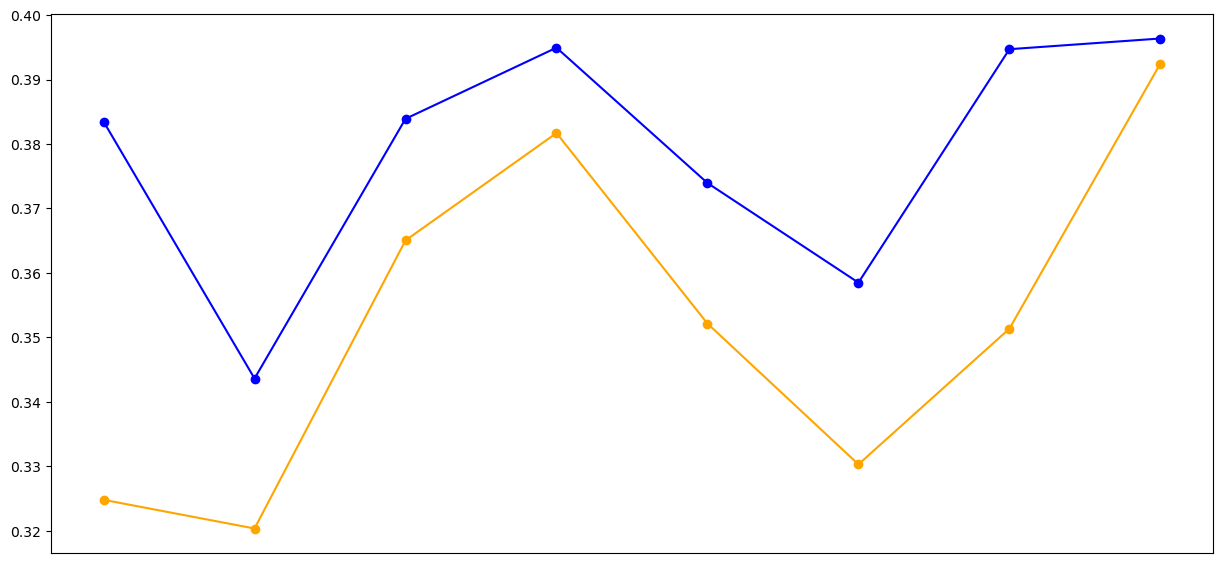

In [472]:
df_2016 = mod_df[mod_df['year'] == 2016].reset_index(drop=True)
df_2018 = mod_df[mod_df['year'] == 2018].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(df_2016.index, df_2016['mod'], label='2016', marker='o', linestyle='-', color='blue')
ax.plot(df_2018.index, df_2018['mod'], label='2018', marker='o', linestyle='-', color='orange')

x_ticks_hours = []
x_ticks_months = []
x_labels_hours = []
x_labels_months = []

# Month mapping to shortened format
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

months_seen = []
for index, row in df_2016.iterrows():
    if row['hour'] in [6, 12, 18]:
        x_ticks_hours.append(index)
        x_labels_hours.append(f"{int(row['hour'])}")
    if row['month'] not in months_seen:
        months_seen.append(row['month'])
        x_ticks_months.append(index)
        x_labels_months.append(month_map[row['month']])

ax.set_xticks(x_ticks_hours)
ax.set_xticklabels(x_labels_hours, rotation=0, ha='center', fontsize=10)
ax.set_xlim([min(x_ticks_hours)-1, max(x_ticks_hours)+2])

# Secondary x-axis for the months
ax2 = ax.twiny()
x_ticks_months_extended = x_ticks_months + [index + len(df_2016) for index in x_ticks_months]
x_labels_months_extended = x_labels_months + x_labels_months

ax2.set_xticks(x_ticks_months_extended)
ax2.set_xticklabels(x_labels_months_extended, fontsize=12, color='gray')
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 50))  
ax2.set_xlim(ax.get_xlim())

# Veertical lines for month separation
for month_tick in x_ticks_months_extended:
    ax.axvline(x=month_tick, color='gray', linestyle='--', alpha=0.7)

# Special hours have red dots
special_hours = [6, 12, 18]
for hour in special_hours:
    special_df_2016 = df_2016[df_2016['hour'] == hour]
    special_df_2018 = df_2018[df_2018['hour'] == hour]
    ax.plot(special_df_2016.index, special_df_2016['mod'], 'ro')
    ax.plot(special_df_2018.index, special_df_2018['mod'], 'ro')

ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('Modularity', fontsize=12)
ax.set_title('Modularity Over Time for 2016 and 2018 (Weekday)', fontsize=14)
ax.legend(fontsize=12)

plt.tight_layout()
plt.grid()
plt.show()


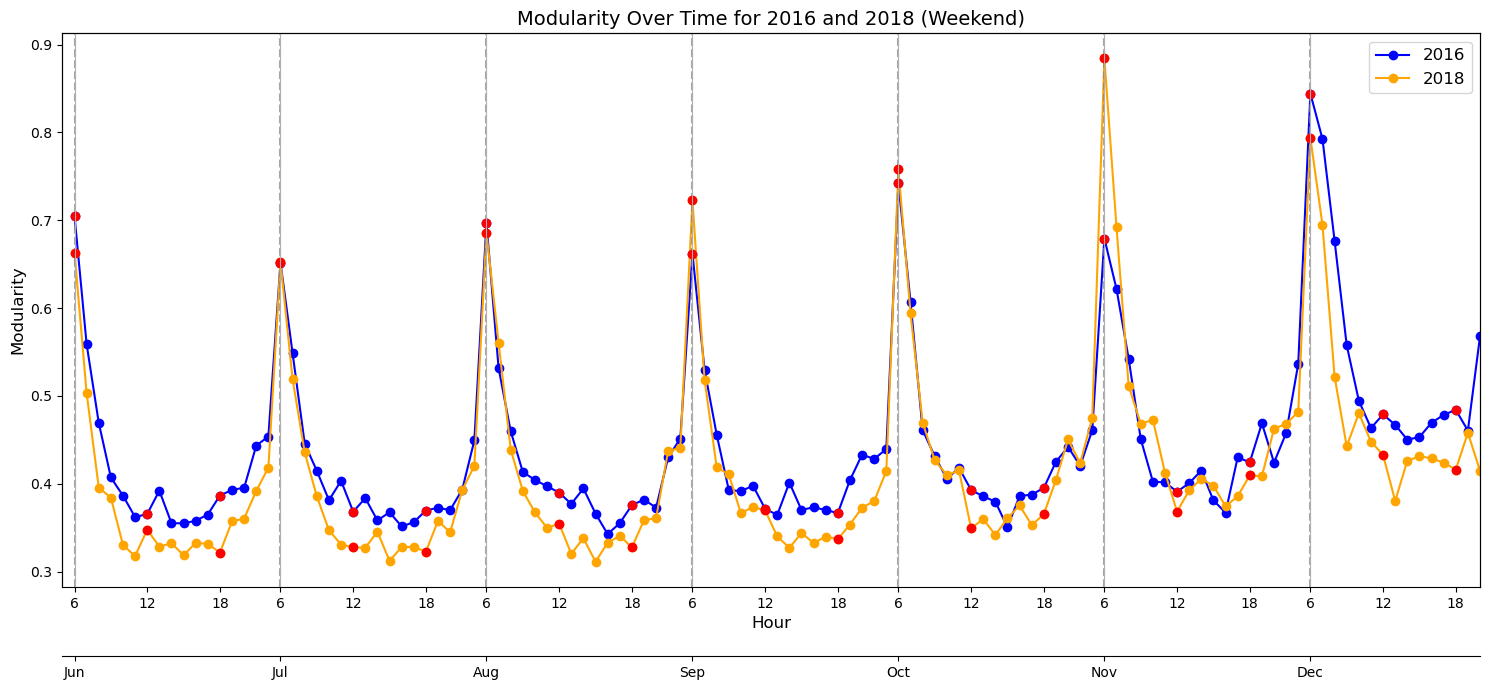

In [238]:
df_2016 = mod_df_weekend[mod_df_weekend['year'] == 2016].reset_index(drop=True)
df_2018 = mod_df_weekend[mod_df_weekend['year'] == 2018].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(df_2016.index, df_2016['mod'], label='2016', marker='o', linestyle='-', color='blue')
ax.plot(df_2018.index, df_2018['mod'], label='2018', marker='o', linestyle='-', color='orange')

x_ticks_hours = []
x_ticks_months = []
x_labels_hours = []
x_labels_months = []

# Month mapping to shortened format
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

months_seen = []
for index, row in df_2016.iterrows():
    if row['hour'] in [6, 12, 18]:
        x_ticks_hours.append(index)
        x_labels_hours.append(f"{int(row['hour'])}")
    if row['month'] not in months_seen:
        months_seen.append(row['month'])
        x_ticks_months.append(index)
        x_labels_months.append(month_map[row['month']])

ax.set_xticks(x_ticks_hours)
ax.set_xticklabels(x_labels_hours, rotation=0, ha='center', fontsize=10)
ax.set_xlim([min(x_ticks_hours)-1, max(x_ticks_hours)+2])

# Secondary x-axis for the months
ax2 = ax.twiny()
x_ticks_months_extended = x_ticks_months + [index + len(df_2016) for index in x_ticks_months]
x_labels_months_extended = x_labels_months + x_labels_months

ax2.set_xticks(x_ticks_months_extended)
ax2.set_xticklabels(x_labels_months_extended, fontsize=12, color='gray')
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 50))  
ax2.set_xlim(ax.get_xlim())

# Veertical lines for month separation
for month_tick in x_ticks_months_extended:
    ax.axvline(x=month_tick, color='gray', linestyle='--', alpha=0.7)

# # Special hours have red dots
special_hours = [6, 12, 18]
for hour in special_hours:
    special_df_2016 = df_2016[df_2016['hour'] == hour]
    special_df_2018 = df_2018[df_2018['hour'] == hour]
    ax.plot(special_df_2016.index, special_df_2016['mod'], 'ro')
    ax.plot(special_df_2018.index, special_df_2018['mod'], 'ro')

ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('Modularity', fontsize=12)
ax.set_title('Modularity Over Time for 2016 and 2018 (Weekend)', fontsize=14)
ax.legend(fontsize=12)

plt.tight_layout()
plt.grid()
plt.show()


## Graph Number of Cluster

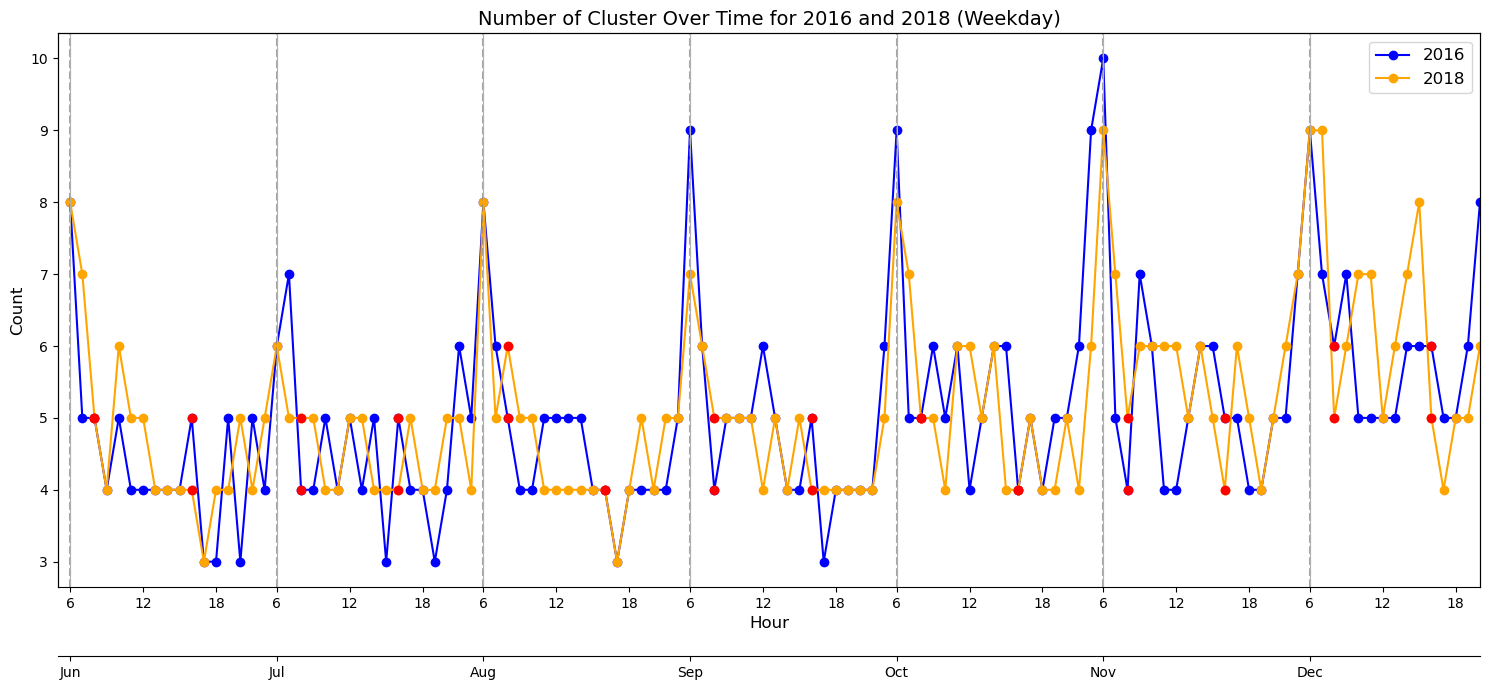

In [239]:
df_2016 = clen_all[clen_all['year']==2016].reset_index(drop=True)
df_2018 = clen_all[clen_all['year']==2018].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(df_2016.index, df_2016['size'], label='2016', marker='o', linestyle='-', color='blue')
ax.plot(df_2018.index, df_2018['size'], label='2018', marker='o', linestyle='-', color='orange')

x_ticks_hours = []
x_ticks_months = []
x_labels_hours = []
x_labels_months = []

# Month mapping to shortened format
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

months_seen = []
for index, row in df_2016.iterrows():
    if row['hour'] in [6, 12, 18]:
        x_ticks_hours.append(index)
        x_labels_hours.append(f"{int(row['hour'])}")
    if row['month'] not in months_seen:
        months_seen.append(row['month'])
        x_ticks_months.append(index)
        x_labels_months.append(month_map[row['month']])

ax.set_xticks(x_ticks_hours)
ax.set_xticklabels(x_labels_hours, rotation=0, ha='center', fontsize=10)
ax.set_xlim([min(x_ticks_hours)-1, max(x_ticks_hours)+2])

# Secondary x-axis for the months
ax2 = ax.twiny()
x_ticks_months_extended = x_ticks_months + [index + len(df_2016) for index in x_ticks_months]
x_labels_months_extended = x_labels_months + x_labels_months

ax2.set_xticks(x_ticks_months_extended)
ax2.set_xticklabels(x_labels_months_extended, fontsize=12, color='gray')
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 50))  
ax2.set_xlim(ax.get_xlim())

# Veertical lines for month separation
for month_tick in x_ticks_months_extended:
    ax.axvline(x=month_tick, color='gray', linestyle='--', alpha=0.7)

# Special hours have red dots
special_hours = [8,16]
for hour in special_hours:
    special_df_2016 = df_2016[df_2016['hour'] == hour]
    special_df_2018 = df_2018[df_2018['hour'] == hour]
    ax.plot(special_df_2016.index, special_df_2016['size'], 'ro')
    ax.plot(special_df_2018.index, special_df_2018['size'], 'ro')

ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Number of Cluster Over Time for 2016 and 2018 (Weekday)', fontsize=14)
ax.legend(fontsize=12)

plt.tight_layout()
plt.grid()
plt.show()

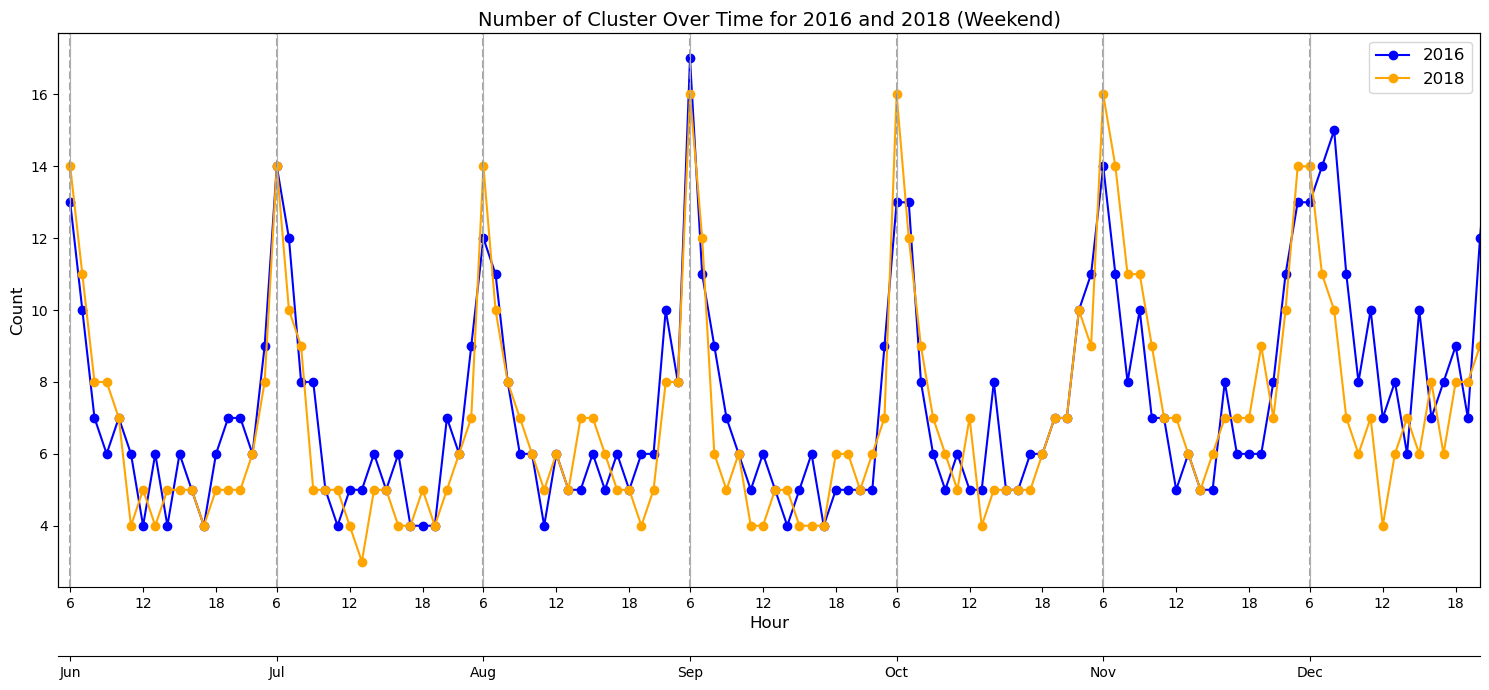

In [240]:
df_2016 = clen_all_weekend[clen_all_weekend['year']==2016].reset_index(drop=True)
df_2018 = clen_all_weekend[clen_all_weekend['year']==2018].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(df_2016.index, df_2016['size'], label='2016', marker='o', linestyle='-', color='blue')
ax.plot(df_2018.index, df_2018['size'], label='2018', marker='o', linestyle='-', color='orange')

x_ticks_hours = []
x_ticks_months = []
x_labels_hours = []
x_labels_months = []

# Month mapping to shortened format
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

months_seen = []
for index, row in df_2016.iterrows():
    if row['hour'] in [6, 12, 18]:
        x_ticks_hours.append(index)
        x_labels_hours.append(f"{int(row['hour'])}")
    if row['month'] not in months_seen:
        months_seen.append(row['month'])
        x_ticks_months.append(index)
        x_labels_months.append(month_map[row['month']])

ax.set_xticks(x_ticks_hours)
ax.set_xticklabels(x_labels_hours, rotation=0, ha='center', fontsize=10)
ax.set_xlim([min(x_ticks_hours)-1, max(x_ticks_hours)+2])

# Secondary x-axis for the months
ax2 = ax.twiny()
x_ticks_months_extended = x_ticks_months + [index + len(df_2016) for index in x_ticks_months]
x_labels_months_extended = x_labels_months + x_labels_months

ax2.set_xticks(x_ticks_months_extended)
ax2.set_xticklabels(x_labels_months_extended, fontsize=12, color='gray')
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 50))  
ax2.set_xlim(ax.get_xlim())

# Veertical lines for month separation
for month_tick in x_ticks_months_extended:
    ax.axvline(x=month_tick, color='gray', linestyle='--', alpha=0.7)

# Special hours have red dots
# special_hours = [6, 12, 18]
# for hour in special_hours:
#     special_df_2016 = df_2016[df_2016['hour'] == hour]
#     special_df_2018 = df_2018[df_2018['hour'] == hour]
#     ax.plot(special_df_2016.index, special_df_2016['108_in'], 'ro')
#     ax.plot(special_df_2018.index, special_df_2018['108_in'], 'ro')

ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Number of Cluster Over Time for 2016 and 2018 (Weekend)', fontsize=14)
ax.legend(fontsize=12)

plt.tight_layout()
plt.grid()
plt.show()

<Figure size 1400x800 with 0 Axes>

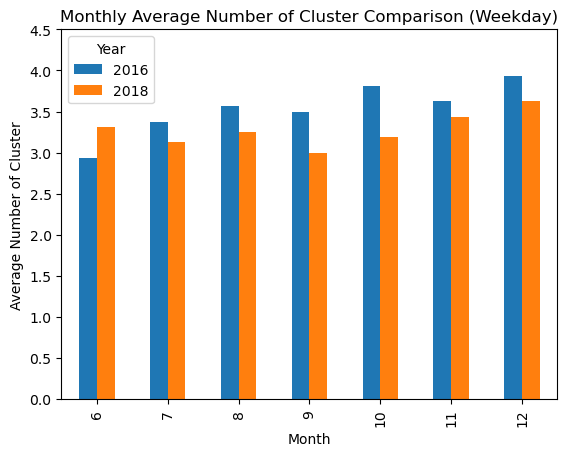

In [241]:
df = clen_part

df_filtered = df[(df['hour'] >= 7) & (df['hour'] <= 23)]
monthly_avg = df_filtered.groupby(['year', 'month'])['size'].mean().unstack(level=0)

plt.figure(figsize=(14, 8))
monthly_avg.plot(kind='bar')
plt.title('Monthly Average Number of Cluster Comparison (Weekday)')
plt.xlabel('Month')
plt.ylabel('Average Number of Cluster')
plt.legend(title='Year', loc='upper left')
plt.ylim(0,4.5)
plt.show()

<Figure size 1400x800 with 0 Axes>

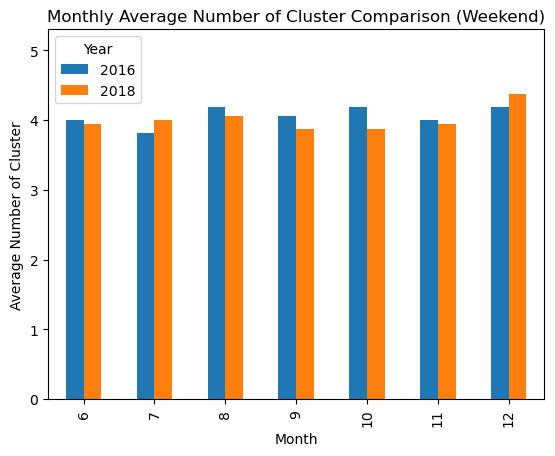

In [242]:
df = clen_part_weekend

df_filtered = df[(df['hour'] >= 7) & (df['hour'] <= 23)]
monthly_avg = df_filtered.groupby(['year', 'month'])['size'].mean().unstack(level=0)

plt.figure(figsize=(14, 8))
monthly_avg.plot(kind='bar')
plt.title('Monthly Average Number of Cluster Comparison (Weekend)')
plt.xlabel('Month')
plt.ylabel('Average Number of Cluster')
plt.legend(title='Year', loc='upper left')
plt.ylim(0,5.3)
plt.show()

## Experiment Bench